In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#The dataset contains cases from a study that was conducted between 1958 and 1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer.
#it is a binary classification problem where 1= the patient survived 5 years or longer, while 2=the patient died within 5 year
haberman = pd.read_csv('/content/drive/MyDrive/MachineLearning/datasets/haberman.csv')
haberman.head()

,age,year of operation,n. of positive axillary nodes detected,survival status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [4]:
#suppose to try to predict if the patient lived or died by consider only 2 feature, i.e age and n. of positive axillary nodes detected 
X = haberman.loc[:,['age','n. of positive axillary nodes detected']].values
labels = haberman.iloc[:,-1].values
#let's replace 2 with 0 = the patient diet withinb 5 year
y = np.where(labels == 2, 0, labels)

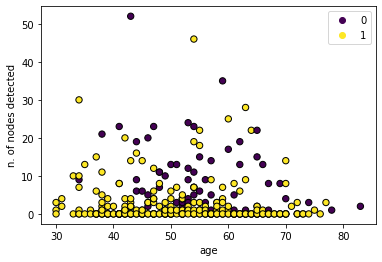

In [5]:
scatt = plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=40, edgecolor="k")
plt.xlabel("age")
plt.ylabel("n. of nodes detected")
plt.legend(handles=scatt.legend_elements()[0], labels=[0,1])
plt.show()

In [6]:
#One of the many qualities of decision Trees is that they require very little data preparation. 
#in particular, they don’t require feature scaling or centering at all.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('n samples in Train set: ', len(X_train))
print('n samples in Test set: ', len(X_test))

n samples in Train set:  244
n samples in Test set:  62


#Decision Tree from scratch#

reference: https://towardsdatascience.com/implementing-a-decision-tree-from-scratch-f5358ff9c4bb

In [7]:
#the main block of a decision tree is the node
#its attributes are: gini impurity score, n. of observations, 
#the n. of observations belonging to each of the binary target classes, the feature matrix X representing the observations that fall into the node.
class Node:
  def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
    self.feature = feature
    self.threshold = threshold
    #left and right child
    self.left = left
    self.right = right
    self.value = value

  def leaf_check(self):
    return self.value is not None

In [8]:
#Decision Tree class
class DecisionTree:
  def __init__(self, max_depth=100, min_samples_split=2):
    #stopping criteria 
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.root = None
  
  #check if the tree is finisheb by looking at the stopping criteria
  #the stopping criterion serves as an exit strategy to stop the recursive growth of the tree.
  def _check_criteria(self, depth):
    if (depth >= self.max_depth or self.labels == 1 or self.n_samples < self.min_samples_split):
      return True
    return False
  #compute entropy loss = -sum pc_hat*log_2(pc_hat) where p_c_hat is the proportion of positives
  def _cross_entropy(self, y):
    # np.bincount = count number of occurrences of each value in array of non-negative ints.
    proportions = np.bincount(y)/len(y)
    loss = 0
    for pc_hat in proportions: 
      if pc_hat>0:
        loss+=pc_hat*np.log2(pc_hat)
    #entropy = -np.sum([p * np.log2(p) for p in proportions if p > 0])
    entropy = -loss
    return entropy
  #define the split 
  def _get_split(self,X,threshold):
    left_idx = np.argwhere(X <= threshold).flatten()
    right_idx = np.argwhere(X > threshold).flatten()
    return left_idx, right_idx
  #compute information gain (Kullback–Leibler divergence)
  #it tells us how much uncertainty could be removed by the proposed split.
  def _get_IG(self, X, y, threshold):
    parent_loss = self._cross_entropy(y)
    left_idx, right_idx = self._get_split(X, threshold)
    n, n_left, n_right = len(y), len(left_idx), len(right_idx)
    if n_left == 0 or n_right == 0: 
      return 0
    child_loss = (n_left/n)*self._cross_entropy(y[left_idx])+(n_right/n)*self._cross_entropy(y[right_idx])
    return parent_loss-child_loss
  
  #compute best split at the current stage. 
  #to get the best split, we loop through all the feature indices and unique threshold values to calculate the information gain. 
  #once we obtain the information gain for the specific feature-threshold combination, we compare the result to our previous iterations. 
  #If we find a better split we store the associated parameters in a dictionary.
  def _get_best_split(self, X, y, features):
    split = {'score':- 1, 'feature': None, 'threshold': None}
    for x_i in features:
      X_i = X[:, x_i]
      thresholds = np.unique(X_i)
      for threshold in thresholds:
        score = self._get_IG(X_i,y,threshold)
        if score > split['score']:
          split['score'] = score
          split['feature'] = x_i
          split['threshold'] = threshold
    return split['feature'], split['threshold']

  #the tree is built recursively starting from the root node
  def _get_tree(self, X, y, depth=0):
    self.n_samples, self.n_features = X.shape
    self.labels = len(np.unique(y))
    # stopping criteria
    if self._check_criteria(depth):
      mc_lab = np.argmax(np.bincount(y))
      return Node(value=mc_lab)

    # get best split
    rnd_feats = np.random.choice(self.n_features, self.n_features, replace=False)
    best_feat, best_thresh = self._get_best_split(X, y, rnd_feats)

    # grow the tree recursively
    #the data are split by using the best feature and the best treshold into a left and right branch
    
    l_idx, r_idx = self._get_split(X[:, best_feat], best_thresh)
    l_child = self._get_tree(X[l_idx, :], y[l_idx], depth + 1)
    r_child = self._get_tree(X[r_idx, :], y[r_idx], depth + 1)
    return Node(best_feat, best_thresh, l_child, r_child)

  #to make a prediction we recursively traverse the tree. For each sample in the dataset we compare the node featureand the treshold values with the current samples value. 
  #then we decide if we have to take a left or right turn.
  def _traverse_tree(self, x, node):
    if node.leaf_check():
      return node.value
    if x[node.feature] <= node.threshold:
      return self._traverse_tree(x, node.left)
    return self._traverse_tree(x, node.right)

  def fit(self, X, y):
    self.root = self._get_tree(X, y)
  #once we reach a leaf node we check the most common class label and it is returned as the prediction.
  def predict(self, X):
    predictions = [self._traverse_tree(x, self.root) for x in X]
    return np.array(predictions)

**Training Phase**

In [9]:
dc_t = DecisionTree(max_depth=2)
dc_t.fit(X_train, y_train)

**Test Phase**

In [10]:
def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred) / len(y_true)
  return accuracy

In [11]:
y_pred = dc_t.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7903225806451613


#SKlearn Implementation and Visualization#

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree
from matplotlib.colors import ListedColormap

decision_tree = DecisionTreeClassifier(max_depth=2)
#here the whole dataset is used since we are aiming to visualize the algorithm boundaries
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [13]:
#test phase
y_pred_sk = decision_tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred_sk)
print('Decision Tree confusion matrix: \n', cm)
print ("Accuracy : ", accuracy_score(y_test, y_pred_sk))
print(classification_report(y_test, y_pred_sk))

Decision Tree confusion matrix: 
 [[10 11]
 [ 1 40]]
Accuracy :  0.8064516129032258
              precision    recall  f1-score   support

           0       0.91      0.48      0.62        21
           1       0.78      0.98      0.87        41

    accuracy                           0.81        62
   macro avg       0.85      0.73      0.75        62
weighted avg       0.83      0.81      0.79        62



**decision tree visualization**

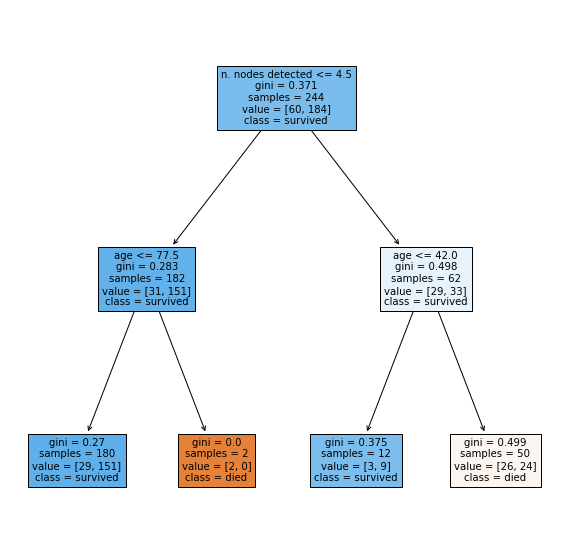

In [14]:
#a node’s samples attribute counts how many training instances it applies to.
#root node is the first node of the tree
#a leaf node (i.e., it does not have any children nodes) does not ask any questions: we can simply look at the predicted class for that node and the Decision Tree predicts
plt.figure(figsize=[10,10])
tree.plot_tree(decision_tree,
               feature_names = ['age','n. nodes detected'], 
               #survived more than 5 year, died within 5 year
               class_names=['died','survived'],
               filled = True);
plt.show()

**Plot of decision boundaries**

Text(0.5, 1.0, 'Decision Tree Boundaries')

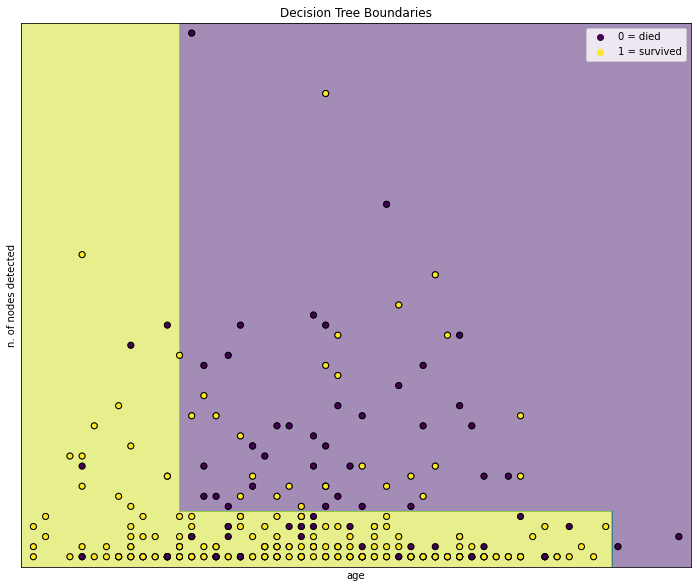

In [15]:
# Plot the decision boundary
figure = plt.figure(figsize=(12, 10))
h = 0.02

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the training points
scat = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o',edgecolor="k")
# and testing points
plt.scatter(X_test[:, 0], X_test[:, 1],c=y_test, marker='o',edgecolor="k")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=.5)
# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o',edgecolor="k")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='o',edgecolor="k")
plt.legend(handles=scat.legend_elements()[0], labels=['0 = died','1 = survived'])
plt.xlabel("age")
plt.ylabel("n. of nodes detected")
plt.title('Decision Tree Boundaries')

#Multi-class Decision Tree#

In [15]:
#let's implement de multi-class decision tree from sklearn by using the Iris dataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris_dataset = load_iris()
#let's use again only two feature: x1=petal length and x2= petal width
X1 = iris_dataset.data[:, 2:] 
#for this dataset we have 3 possibile classes
y1 = iris_dataset.target

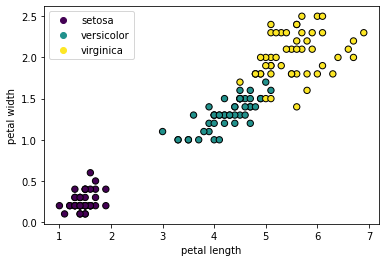

In [16]:
scatt1 = plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=y1, s=40, edgecolor="k")
plt.legend(handles=scatt1.legend_elements()[0], labels=['setosa','versicolor','virginica'])
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.show()

In [17]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.2, shuffle=True)
print('n samples in Train set: ', len(X_train1))
print('n samples in Test set: ', len(X_test1))

n samples in Train set:  120
n samples in Test set:  30


In [18]:
#let's evaluate the decision tree with the all dataset
multi_class_dt = DecisionTreeClassifier(max_depth=3)
#training
multi_class_dt.fit(X_train1, y_train1)

DecisionTreeClassifier(max_depth=3)

In [19]:
#test phase
y_preds1 = multi_class_dt.predict(X_test1)
cm1 = confusion_matrix(y_test1, y_preds1)
print('Multi-class Decision Tree confusion matrix: \n', cm1)
print ("Accuracy : ", accuracy_score(y_test1, y_preds1))
print(classification_report(y_test1, y_preds1))

Multi-class Decision Tree confusion matrix: 
 [[ 7  0  0]
 [ 0 10  0]
 [ 0  1 12]]
Accuracy :  0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.91      1.00      0.95        10
           2       1.00      0.92      0.96        13

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



**multi-class decision tree visualization**

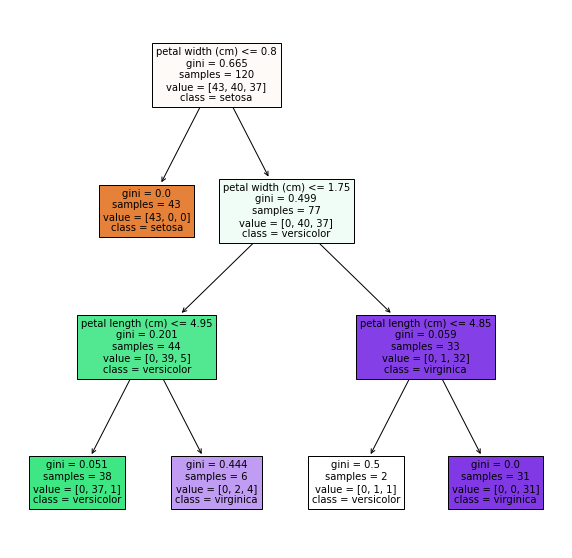

In [20]:
#tree visualization
plt.figure(figsize=[10,10])
tree.plot_tree(multi_class_dt,
               feature_names = iris_dataset.feature_names[2:], 
               class_names=iris_dataset.target_names,
               filled = True);
plt.show()

**decision boundaries visualization**

Text(0.5, 1.0, 'Multi-class Decision Tree Boundaries')

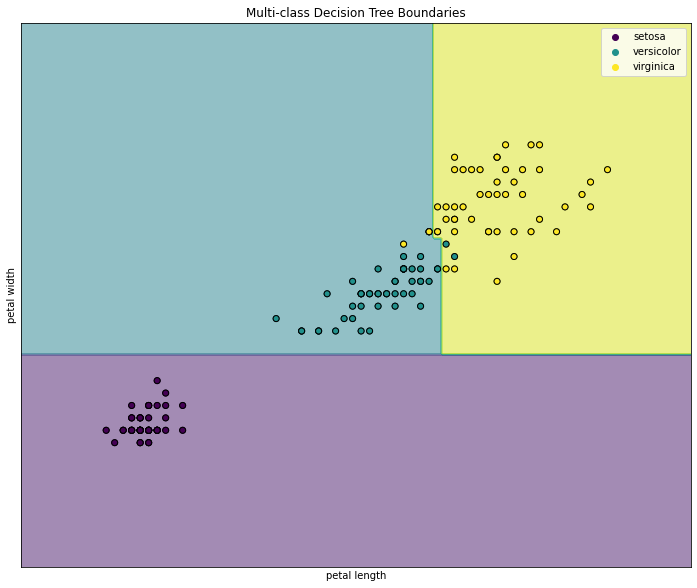

In [21]:
# Plot the decision boundary
figure = plt.figure(figsize=(12, 10))
h = 0.02

x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the training points
scat1 = plt.scatter(X_train1[:, 0], X_train1[:, 1], c=y_train1, marker='o',edgecolor="k")
# and testing points
plt.scatter(X_test1[:, 0], X_test1[:, 1],c=y_test1, marker='o',edgecolor="k")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = multi_class_dt.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx,yy,Z,alpha=.5)
# Plot also the training points
plt.scatter(X_train1[:, 0], X_train1[:, 1], c=y_train1, marker='o',edgecolor="k")
plt.scatter(X_test1[:, 0], X_test1[:, 1], c=y_test1, marker='o',edgecolor="k")
plt.legend(handles=scat1.legend_elements()[0], labels=['setosa','versicolor','virginica'])
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.title('Multi-class Decision Tree Boundaries')